In [14]:
import os
import glob
import xarray as xr

prf = 7500.

def get_iq(radar):
    return radar.co[0,:,:].astype(float) + 1j * radar.co[1,:,:].astype(float)

def get_pwr(radar, noise=125, smooth=None):
    import scipy as sp

    pwr = radar.co[0,:,:].astype(float)**2 + radar.co[1,:,:].astype(float)**2
    if smooth != None:
        if smooth['type'] == 'gaussian':
            gauss  = sp.signal.windows.gaussian(smooth['window'],smooth['length'])
            wghts  = gauss/gauss.sum()
            print ('filtering with gaussian')
        else:
            print ('selected smoothing not supported')
        pwr = xr.DataArray( sp.signal.fftconvolve(pwr,wghts[np.newaxis,:],mode='same', axes=-1),
                               dims=["range","time",],
                               coords={"range":("range",dx.range.data),"time":("time",dx.pulse_time.data)}
                               ) 
    return pwr.where(pwr>noise)

zarr_path   = "/Users/m219063/Research/Projects/orcestra/data/radar-iq3/"
fout = f'{zarr_path}/HALO-20240811a-iq_1536-1608.zarr'
if (os.path.isdir(fout)):
    print (f"{fout} exists, opening")
    ds = xr.open_zarr(fout)
else:
    print (f'{fout} does not exist, creating from cocx and frms files')
    pds_path  = "/Users/m219063/Research/Projects/orcestra/data/radar-pds/"
    files = sorted(os.listdir(pds_path))
    files = [pds_path + x for x in files]
    #untangle_iqf(files[:2],zarr_path)

    cocx_files = sorted(glob.glob(zarr_path + '*cocx.zarr'))
    frms_files = sorted(glob.glob(zarr_path + '*frms.zarr'))
    ds = merge_iqf(cocx_files,frms_files)
    ds.to_zarr(fout)

/Users/m219063/Research/Projects/orcestra/data/radar-iq3//HALO-20240811a-iq_1536-1608.zarr does not exist, creating from cocx and frms files


In [15]:
xr.open_zarr("/Users/m219063/Research/Projects/orcestra/data/radar-iq3//HALO-20240811a-iq_1536-1608.zarr")

<xarray.Dataset> Size: 4GB
Dimensions:     (frame: 3880, iq: 2, range: 512, pulse_time: 993280)
Coordinates:
  * frame       (frame) datetime64[ns] 31kB 2024-08-11T15:35:53.774102 ... 20...
  * iq          (iq) <U1 8B 'i' 'q'
  * pulse_time  (pulse_time) datetime64[ns] 8MB 2024-08-11T15:35:53.774102 .....
  * range       (range) float64 4kB 150.0 181.2 212.3 ... 1.605e+04 1.608e+04
Data variables:
    TPow        (frame) float32 16kB dask.array<chunksize=(1940,), meta=np.ndarray>
    co          (iq, range, pulse_time) int16 2GB dask.array<chunksize=(1, 32, 31040), meta=np.ndarray>
    co_CPw      (frame) float32 16kB dask.array<chunksize=(1940,), meta=np.ndarray>
    co_NPw      (frame) float32 16kB dask.array<chunksize=(1940,), meta=np.ndarray>
    cx          (iq, range, pulse_time) int16 2GB dask.array<chunksize=(1, 32, 31040), meta=np.ndarray>
    cx_CPw      (frame) float32 16kB dask.array<chunksize=(1940,), meta=np.ndarray>
    cx_NPw      (frame) float32 16kB dask.array<chunksize=(1940,), meta=np.ndarray>

In [5]:
# this performs some optional diagnostics on the files that are being processed

for file in files[0:2]:
    t0,t1,frm0,frm1,nblk = get_pdsinfo(pds_path+file,blocks_of_output=3)
    freq = 1./((t1-t0).total_seconds()/nblk/256)
    print (f"\n{file} contains {nblk} frames in total, sparning {(t1-t0).total_seconds()/60:.2f} min, with an implied sampling frequency of {freq:.2f} Hz" )


Frame number 550942, at 2024-08-11 15:35:53.774102 and 1.602927923727293e-08
Frame number 550943, at 2024-08-11 15:35:53.808279 and 1.59399871080268e-08
Frame number 550944, at 2024-08-11 15:35:53.842353 and 1.5931059138551973e-08

240811_153553.pds contains 1940 frames in total, sparning 1.10 min, with an implied sampling frequency of 7504.13 Hz
Frame number 552882, at 2024-08-11 15:36:59.990427 and 1.5324296498420154e-08
Frame number 552883, at 2024-08-11 15:37:00.024595 and 1.5063562841532985e-08
Frame number 552884, at 2024-08-11 15:37:00.058654 and 1.5290849475491086e-08

240811_153659.pds contains 1940 frames in total, sparning 1.10 min, with an implied sampling frequency of 7504.13 Hz


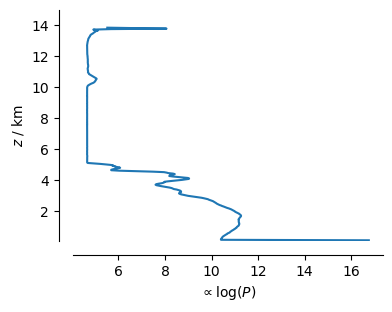

In [12]:
# sanity check analysis
 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

dx    = ds.sel(pulse_time=('2024-08-11T15:49'))
pwr   = dx.co[0,:,:].astype(float)**2 + dx.co[1,:,:].astype(float)**2
lnpwr = np.log(pwr.mean(dim='pulse_time'))

fig, ax = plt.subplots(
        figsize=(4, 3),
        facecolor='white'
        )

ax.plot(lnpwr[440::-1], (14000 - dx.range[440::-1])/1000.)
ax.set_ylim(0.1,15.)
ax.set_ylabel('$z$ / km')
ax.set_xlabel('$\\propto \\log(P)$')
#ax.hlines(0.,xmin=10,xmax=20,ls='dotted',lw=1)

sns.despine(offset=10)



In [62]:
# this takes about 3 min for a 4 min section

import scipy.signal as sp
import numpy as np
import seaborn as sns

dx     = ds.sel(pulse_time=slice('2024-08-11T15:48','2024-08-11T15:50'))
pwr    = get_pwr(dx, noise=125, smooth= {'type' : 'gaussian', 'length' : 64, 'window' : 256})
ref_dB = (10*np.log( pwr.where(pwr>125.) * dx.range**2 ))


filtering with gaussian


In [252]:
# set parameters for analysis
fft_window1 = [np.datetime64("2024-08-11T15:39:00"),np.datetime64("2024-08-11T15:39:01")]
fft_window2 = [np.datetime64("2024-08-11T16:01:20"),np.datetime64("2024-08-11T16:01:21")]
fft_window2 = [np.datetime64("2024-08-11T15:48:45"),np.datetime64("2024-08-11T15:48:50")]

fft_window = fft_window2

dy = ds.sel(pulse_time=slice(fft_window[0],fft_window[1]))
nfft = 256
inds = np.asarray([5,50,100,120])
nfrms  = np.floor_divide(len(dy.pulse_time),nfft)
nfreq  = np.floor_divide(nfft,2)
isfc = 344



0.0 [12.31178064 10.90917272  9.35071947  8.72733818]


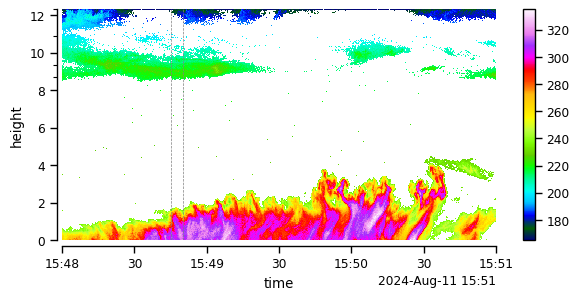

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

height = (dx.range[isfc] - dx.range[:]).data/1000

stride = 16
xx  = xr.DataArray(
    ref_dB[isfc:5:-1,::stride],
    dims=("height","time"),
    coords={"height":("height",height[isfc:5:-1]),"time":("time",dx.pulse_time.data[::stride])}
)

fig, ax = plt.subplots(
        figsize=(7, 3),
        ncols = 1,
        facecolor='white'
        )
ze = xx.plot.imshow(ax=ax,cmap='gist_ncar',add_colorbar=False,vmin=165,vmax=335)
ax.axvline(x=fft_window[0],ls='dashed',color='grey',lw=0.5)
ax.axvline(x=fft_window[1],ls='dashed',color='grey',lw=0.5)
ax.set_yticks(height[inds],minor='TRUE')

sns.despine(offset=4)

fig.colorbar(ze)
print (xx.height[0].values,height[inds])

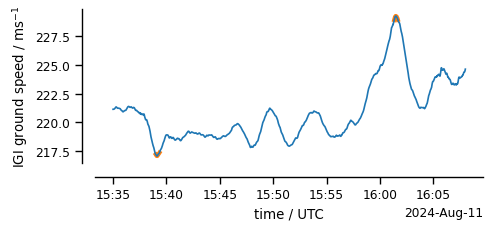

In [244]:
fig, ax = plt.subplots(
        figsize=(5, 2),
        ncols = 1,
        facecolor='white',
        )

sns.set_context("paper")
bahamas.IRS_GS.sel(time=slice('2024-08-11T15:39','2024-08-11T15:39:20')).plot(lw=3,color='tab:orange',ax=ax)
bahamas.IRS_GS.sel(time=slice('2024-08-11T16:01:20','2024-08-11T16:01:40')).plot(lw=3,color='tab:orange',ax=ax)
bahamas.IRS_GS.plot()
ax.set_ylabel("IGI ground speed / ms$^{-1}$")
ax.set_xlabel("time / UTC")
sns.despine(offset=10)
wmx = bahamas.IRS_VV.sel(time=slice(fft_window[0],fft_window[1])).max()
wmn = bahamas.IRS_VV.sel(time=slice(fft_window[0],fft_window[1])).min()

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_9/hj56_qws3tx_n_y2gn3mqnxr0000gn/T/ipykernel_9214/1176134952.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel("$v_\mathrm{doppler}$ / ms$^{-1}$")


37502 37376
fields 10.99,10.90,2.85


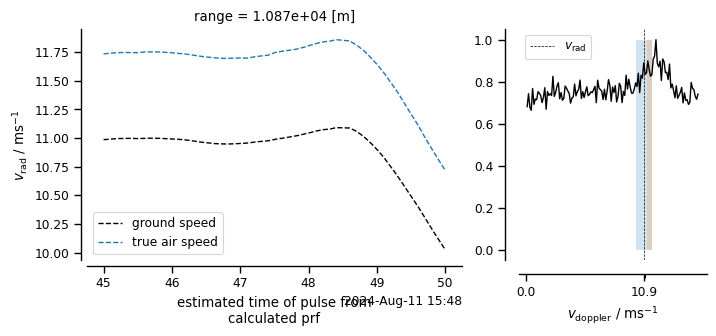

In [256]:
import scipy.fft as scipy_fft

import orcestra.postprocess.level0

sns.set_context('paper')
od_path = "/Users/m219063/Research/Projects/orcestra/data/"
bahamas = (xr.open_dataset(od_path+"BAHAMAS/QL_HALO-20240811a_BAHAMAS_V01.nc")
           .pipe(orcestra.postprocess.level0.bahamas)
           .sel(time=slice("2024-08-11T15:35","2024-08-11T16:07"))
)
co_iq1 = get_iq(dy)[isfc,:]
print (len(co_iq1),nfft*nfrms)

gspd = bahamas.IRS_GS * np.sin(np.deg2rad(bahamas.IRS_THE))
dv   = (bahamas.IRS_GS * np.sin(np.deg2rad(0.2))).interp(time=co_iq1.pulse_time).mean()
aspd = bahamas.TAS * np.sin(np.deg2rad(bahamas.IRS_THE))

fig, (ax1,ax2) = plt.subplots(
        figsize=(8, 3),
        ncols = 2,
        width_ratios = [1,0.5],
        facecolor='white',
        )

(gspd.interp(time=co_iq1.pulse_time))[:].plot(ax=ax1,ls='dashed',color='k',label='ground speed',lw=1)
(aspd.interp(time=co_iq1.pulse_time))[:].plot(ax=ax1,ls='dashed',label='true air speed',lw=1)
rvbar = (gspd.interp(time=co_iq1.pulse_time).mean())
ax1.set_ylabel("$v_\\mathrm{rad}$ / ms$^{-1}$")
sns.despine(offset=4,ax=ax1)

vel   = scipy_fft.fftfreq(nfft, d=1.0/7500.)[1:int(nfreq)] / 35.2e9*3e8/2

co_td = np.asarray(np.reshape(co_iq1.data[:nfrms*nfft],(nfrms,nfft)))
co_fd = scipy_fft.fft(co_td)
co_ps = np.absolute(co_fd[:nfrms,:]).mean(axis=0)[1:int(nfreq)]

co_td_windowed = co_td*(sp.windows.hann(nfft)[np.newaxis,:])
co_fd_windowed = scipy_fft.fft(co_td_windowed)
co_ps_windowed = np.absolute(co_fd_windowed[:nfrms,:]).mean(axis=0)[1:nfreq]

norm = co_ps.max()
ax2.plot(vel,co_ps/norm, color='k', lw=1)
vmom = (co_ps[co_ps>1.2*co_ps.min()]*vel[co_ps>1.2*co_ps.min()]).sum()/(co_ps[co_ps>1.2*co_ps.min()].sum())
ax2.axvline(x=rvbar,ls='dashed',color='k',label='$v_\\mathrm{rad}$', lw=0.5)
ax2.fill_betweenx([0,1.0],[rvbar-dv,rvbar-dv],[rvbar+dv,rvbar+dv], alpha=0.2)
ax2.fill_betweenx([0,1.0],[rvbar+wmn,rvbar+wmn],[rvbar+wmx,rvbar+wmx], alpha=0.2)
ax2.set_xticks([0,np.round(rvbar,2)])
ax2.set_xticks([vmom,],minor=True)

ax2.set_xlabel("$v_\mathrm{doppler}$ / ms$^{-1}$")
sns.despine(offset=10,ax=ax2)
ax2.legend()
ax1.legend()
print (f"fields {vmom:.2f},{rvbar.values:.2f},{bahamas.IRS_THE.interp(time=co_iq1.pulse_time).mean().values:.2f}")

13.4
32 31 31
12.0
32 31 31
10.4
32 31 31
9.8
32 31 31
0.0
32 31 31


/var/folders/_9/hj56_qws3tx_n_y2gn3mqnxr0000gn/T/ipykernel_8026/239729763.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/var/folders/_9/hj56_qws3tx_n_y2gn3mqnxr0000gn/T/ipykernel_8026/239729763.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/var/folders/_9/hj56_qws3tx_n_y2gn3mqnxr0000gn/T/ipykernel_8026/239729763.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.

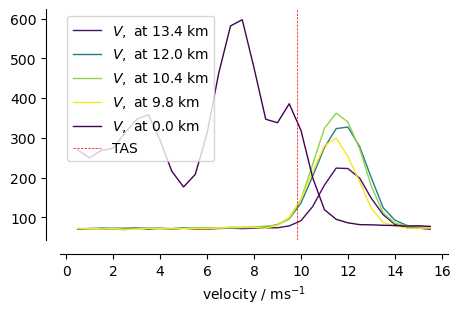

In [75]:
import scipy.fft as scipy_fft
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#noise = np.percentile(sig, 1.)
#print ('velocity ', np.sum(sig[sig>1.4*noise] * vv[sig>1.4*noise])/np.sum(sig[sig>1.4*noise] ))

fig, ax = plt.subplots(
        figsize=(5, 3),
        ncols = 1,
        facecolor='white'
        )

co_iq2 = get_iq(dx.sel(pulse_time=slice(fft_window[0],fft_window[1])))[5:440,:]
nfrms  = np.floor_divide(len(co_iq2.pulse_time),nfft)
nfreq  = np.floor_divide(nfft,2)
for igt in inds:

    zkm    = np.round((co_iq2.range[-1]-co_iq2.range[igt]).data/1000.,1)
    print (zkm)
    co_iq1 = co_iq2[igt,:]
    vel   = scipy_fft.fftfreq(nfft, d=1.0/7500.)[1:int(nfreq)] / 35.2e9*3e8/2

    co_td = np.asarray(np.reshape(co_iq1.data[:nfrms*nfft],(nfrms,nfft)))
    co_fd = scipy_fft.fft(co_td)
    co_ps = np.absolute(co_fd[:nfrms,:]).mean(axis=0)[1:int(nfreq)]

    co_td_windowed = co_td*(sp.windows.hann(nfft)[np.newaxis,:])
    co_fd_windowed = scipy_fft.fft(co_td_windowed)
    co_ps_windowed = np.absolute(co_fd_windowed[:nfrms,:]).mean(axis=0)[1:nfreq]

    print (int(nfreq),len(vel),len(co_ps))
    cmap = matplotlib.cm.get_cmap('viridis')

    rgba = cmap(igt/(max(inds)-min(inds)))
    ax.plot(vel,co_ps, label = f"$V,$ at {zkm} km", color=rgba, lw=1)

ax.axvline(x=rvbar,ls='dashed',color='red',label='TAS', lw=0.5)
ax.set_xlabel("velocity / ms$^{-1}$")
sns.despine(offset=10)

plt.legend()



In [60]:
bahamas

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 19800)
Coordinates:
  * time       (time) datetime64[ns] 158kB 2024-08-11T15:35:00 ... 2024-08-11...
Data variables: (12/45)
    IGI_RMSX   (time) float32 79kB ...
    IGI_RMSY   (time) float32 79kB ...
    IGI_RMSZ   (time) float32 79kB ...
    IRS_ALT    (time) float32 79kB ...
    IRS_ATA    (time) float32 79kB ...
    IRS_AXB    (time) float32 79kB ...
    ...         ...
    TS         (time) float32 79kB ...
    RELHUM     (time) float32 79kB ...
    SOURCE     (time) float32 79kB ...
    WS         (time) float32 79kB ...
    MIXRATIOV  (time) float32 79kB ...
    MIXRATIO   (time) float32 79kB ...
Attributes: (12/19)
    title:                Quality controlled data of DLR measurment flight ad...
    aircraft:             D-ADLR
    project:              PERCUSION
    mission:              PERCUSION
    ProjectInvestigator:  Bjorn Stevens
    flightname:           adlr_20240811a
    ...                   ...
    date_last_revised:    2024-8-12
    TimeInterval:         11:59:34 - 20:35:59
    comment:               Attention: only quicklook data! Humidity is measur...
    platform:             HALO
    instrument:           BAHAMAS
    Variablelist:          TIME IGI_RMSX IGI_RMSY IGI_RMSZ IRS_ALT IRS_ATA IR...

In [40]:
300*128/7500.

5.12

In [89]:

z      = bahamas.IRS_ALT.interp(time=dx.pulse_time)
radvel = bahamas.TAS * np.sin(np.deg2rad(bahamas.IRS_THE)).interp(time=dx.pulse_time)
dz     = dx.range.diff(dim='range').values[0]
idxs   = ((z - 150)/dz).astype(int)
print (idxs)
pwr0 = (dx.co[0, idxs  , np.arange(len(idxs))].astype(float)**2 + dx.co[1, idxs  , np.arange(len(idxs))].astype(float)**2)
pwr1 = (dx.co[0, idxs+1, np.arange(len(idxs))].astype(float)**2 + dx.co[1, idxs+1, np.arange(len(idxs))].astype(float)**2)

: 

In [114]:
sfc_pwr = pwr0+pwr1
sfc_pwr_mx = np.max(np.log(sfc_pwr))
sfc_dB = xr.DataArray(np.log(sp.convolve(sfc_pwr,wghts,mode='same')), dims=["time",], coords={"time":("time",dx.pulse_time.data)})


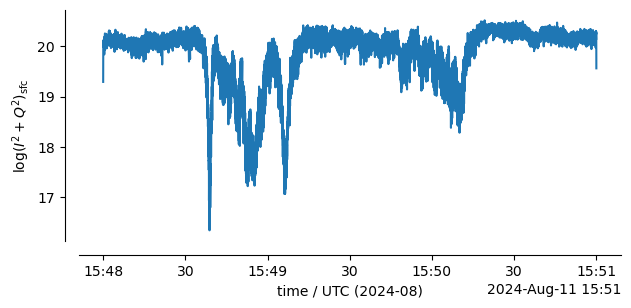

In [129]:
fig, ax = plt.subplots(
        figsize=(7, 3),
        ncols = 1,
        facecolor='white'
        )

sfc_dB.plot(ax=ax)
ax.set_ylabel('$\\log (I^2+Q^2)_\\mathrm{sfc}$')
ax.set_xlabel('time / UTC (2024-08)')

sns.despine(offset=10)

In [242]:
import pandas as pd
import datetime as dt
print (f'{str(xtime[0].data)[11:16]}')

15:48


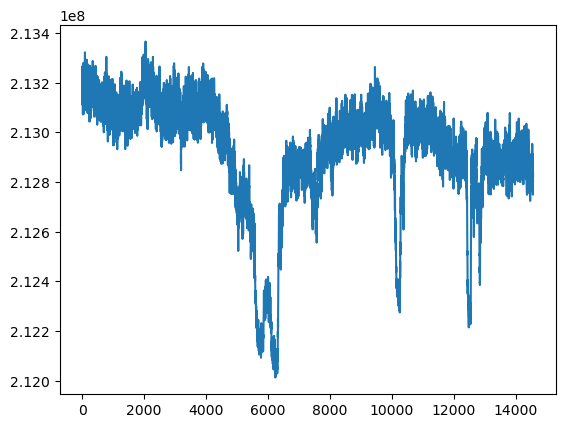

In [108]:
import matplotlib.pyplot as plt

dx     = ds#.sel(pulse_time=slice('2024-08-11T15:40','2024-08-11T15:55'))

gsig   = 1024
gauss  = sp.windows.gaussian(gsig*2,gsig)
w2     = gauss/gauss.sum()
p510   = (dx.co[0,510,:].astype(float)**2 + dx.co[1,510,:].astype(float)**2).squeeze()
p511   = (dx.co[0,511,:].astype(float)**2 + dx.co[1,511,:].astype(float)**2).squeeze()

#plt.plot(np.log(ds.TPow/ds.TPow.mean()))
x2 = sp.fftconvolve(p511.values,w2,mode='valid'),
plt.plot(x2[0][::gsig])

[    0.          29.296875    58.59375     87.890625   117.1875
   146.484375   175.78125    205.078125   234.375      263.671875
   292.96875    322.265625   351.5625     380.859375   410.15625
   439.453125   468.75       498.046875   527.34375    556.640625
   585.9375     615.234375   644.53125    673.828125   703.125
   732.421875   761.71875    791.015625   820.3125     849.609375
   878.90625    908.203125   937.5        966.796875   996.09375
  1025.390625  1054.6875    1083.984375  1113.28125   1142.578125
  1171.875     1201.171875  1230.46875   1259.765625  1289.0625
  1318.359375  1347.65625   1376.953125  1406.25      1435.546875
  1464.84375   1494.140625  1523.4375    1552.734375  1582.03125
  1611.328125  1640.625     1669.921875  1699.21875   1728.515625
  1757.8125    1787.109375  1816.40625   1845.703125  1875.
  1904.296875  1933.59375   1962.890625  1992.1875    2021.484375
  2050.78125   2080.078125  2109.375     2138.671875  2167.96875
  2197.265625  2226.5625   

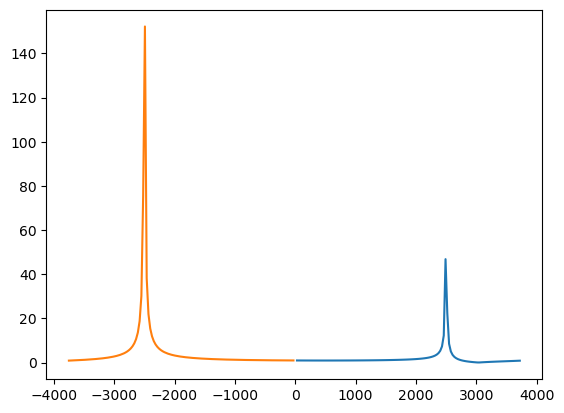

In [243]:
f = 35.2e9
fs = 7500.
omega = np.pi * 2 * f
a = .5
ns = int(nfft/2)

s = lambda t: a*np.sin(omega*t) + 1j * np.cos(omega*t) * np.sqrt(1-a**3)
y = np.arange(1,13.,1./fs)
x = scipy_fft.fftfreq(nfft, d=1.0/7500.)
plt.plot(x[1:ns],np.absolute(scipy_fft.fft(s(y[0:nfft])))[1:ns])
plt.plot(x[-ns:],np.absolute(scipy_fft.fft(s(y[0:nfft])))[-ns:])
print (x)

In [31]:
print(np.log(ref_pwr[511,100:-100]).mean())
print(np.log(ref_pwr[510,100:-100]).mean())
print(np.log(ref_pwr[441,100:-100]).mean())
print(2**13)

<xarray.DataArray ()> Size: 8B
array(19.1740152)
Coordinates:
    range    float64 8B 1.608e+04
<xarray.DataArray ()> Size: 8B
array(6.98990993)
Coordinates:
    range    float64 8B 1.605e+04
<xarray.DataArray ()> Size: 8B
array(19.76493293)
Coordinates:
    range    float64 8B 1.39e+04
8192


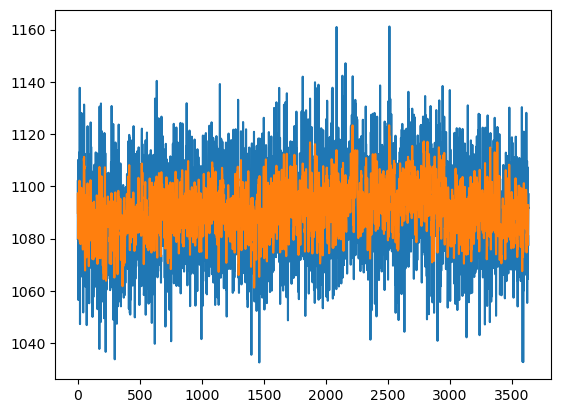

In [18]:
x2 = sp.fftconvolve(f2.values,np.ones(4096)/4096,mode='valid'),
plt.plot(x2[0][::4096])
x2 = sp.fftconvolve(f2.values,np.ones(4096*4)/(4096*4),mode='valid'),
plt.plot(x2[0][::4096])

23.779943 0.54924


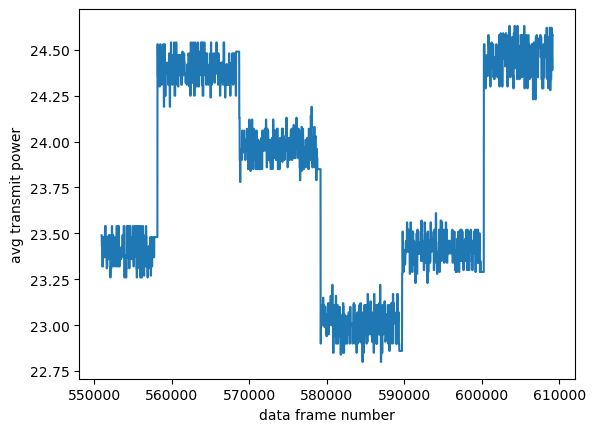

In [103]:
fld = "TPow"
dx[fld].plot()
print (dx[fld].mean().values,dx[fld].std().values)

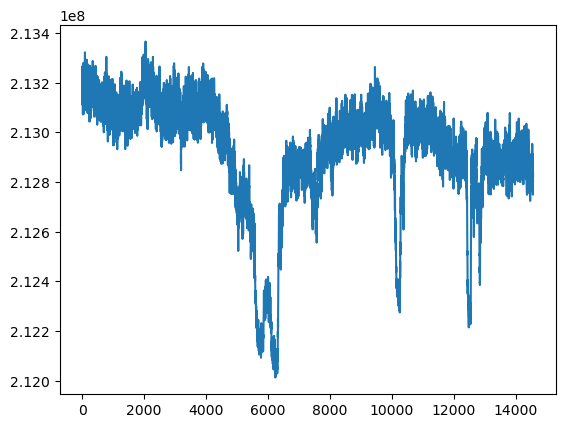

In [107]:
x2 = sp.fftconvolve(p511.values,w2,mode='valid'),
plt.plot(x2[0][::gsig])
#p511.coarsen(pulse_time=4096, boundary="trim").mean().plot()

In [99]:
igate = 511
print (f'{dx.co[0,300,:].min().values} {dx.co[0,300,:].max().values} {np.sqrt((dx.co[0,300,:].astype(float)**2).mean()).values}')
print (f'{dx.co[1,440,:].min().values} {dx.co[1,440,:].max().values} {np.sqrt((dx.co[1,440,:].astype(float)**2).mean()).values}')
print (f'{dx.co[0,510,:].min().values} {dx.co[0,510,:].max().values} {np.sqrt((dx.co[0,510,:].astype(float)**2).mean()).values}')
print (f'{dx.co[0,511,:].min().values} {dx.co[0,511,:].max().values} {np.sqrt((dx.co[0,511,:].astype(float)**2)).mean().values}')
print (f'{dx.cx[0,300,:].min().values} {dx.cx[0,300,:].max().values} {np.sqrt((dx.cx[0,300,:].astype(float)**2).mean()).values}')
print (f'{dx.cx[1,440,:].min().values} {dx.cx[1,440,:].max().values} {np.sqrt((dx.cx[1,440,:].astype(float)**2).mean()).values}')
print (f'{dx.cx[0,510,:].min().values} {dx.cx[0,510,:].max().values} {np.sqrt((dx.cx[0,510,:].astype(float)**2).mean()).values}')
print (f'{dx.cx[0,511,:].min().values} {dx.cx[0,511,:].max().values} {np.sqrt((dx.cx[0,511,:].astype(float)**2)).mean().values}')

-1289 1293 14.111870841680654
-32742 32693 6230.611009336264
-121 123 23.359872775816676
14371 14731 14591.79439688037
-116 120 7.316352330460318
-15554 15344 1444.7983899169383
-146 140 27.167875595030964
0 0 0.0
